In [52]:
import sympy as sp
import numpy as np
from sympy import latex
from IPython.display import display, Math
import scipy
import time
import matplotlib.pyplot as plt

1、状态空间模型

In [53]:
x1,x2,x3,x4 = sp.symbols('x1 x2 x3 x4')
u, mp, L, mc, g = sp.symbols('u mp L mc g')

# 定义状态空间模型
x1_dot = x3
x2_dot = -x4
x3_dot = (u + mp * sp.sin(x2) * (L * x4**2 - g * sp.cos(x2))) / (mc + mp * sp.sin(x2)**2)
x4_dot = (u * sp.cos(x2) + mp * L * x4**2 * sp.cos(x2) * sp.sin(x2) - (mc + mp) * g * sp.sin(x2)) / (L * mc + L * mp * sp.sin(x2)**2)

'''
print(f'x1_dot: ', x1_dot)
print(f'x2_dot: ', x2_dot)
print(f'x3_dot: ', x3_dot)
print(f'x4_dot: ', x4_dot)
'''

display(Math(r"{\dot{x}_1} =" + latex(x1_dot)))
display(Math(r"{\dot{x}_2} =" + latex(x2_dot)))
display(Math(r"{\dot{x}_3} =" + latex(x3_dot)))
display(Math(r"{\dot{x}_4} =" + latex(x4_dot)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

2、在平衡点处线性化
求偏导

In [54]:
X = [x1, x2, x3, x4]
f = [x1_dot, x2_dot, x3_dot, x4_dot]
U = [u]
# 计算雅可比矩阵（偏导数矩阵）
pfx = sp.Matrix(len(f), len(X), lambda i, j: sp.diff(f[i], X[j]))
pfu = sp.Matrix(len(f), len(U), lambda i, j: sp.diff(f[i], U[j]))
'''
for i in range(len(f)):
    for j in range(len(X)):
        print(f'pf{i+1}x{j+1}:', pfx[i, j])
    print()

for i in range(len(f)):
    for j in range(len(U)):
        print(f'pf{i+1}u{j+1}:', pfu[i, j])
    print()
'''
# 输出雅可比矩阵 ∂f/∂x
display(Math(r"\frac{\partial f}{\partial x} = " + latex(pfx)))

# 输出雅可比矩阵 ∂f/∂u
display(Math(r"\frac{\partial f}{\partial u} = " + latex(pfu)))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

在x = 0，u = 0处线性化

In [55]:
x1_hat,x2_hat,x3_hat,x4_hat = 0,0,0,0
u_hat = 0
mp_value = 1
mc_value = 10
g_value = 9.81
L_value = 0.5
subs_list = [
    (x1, x1_hat), (x2, x2_hat), (x3, x3_hat), (x4, x4_hat),
    (u, u_hat), (mp, mp_value), (mc, mc_value), (g, g_value), (L, L_value)
]
A_hat = pfx.subs(subs_list).evalf()
B_hat = pfu.subs(subs_list).evalf()

#转化为numpy矩阵
#A_hat = np.array(A_hat.tolist()).astype(np.float64)
#B_hat = np.array(B_hat.tolist()).astype(np.float64)

display(Math(r"{\hat{A}} = " + latex(A_hat)))
display(Math(r"{\hat{B}} = " + latex(B_hat)))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

3、离散时间动力学模型

In [56]:
det_T = 0.002  # 设置步长

# 离散化
A_discrete = np.eye(4) + det_T * A_hat
B_discrete = det_T * B_hat

display(Math(r"A_d = " + latex(A_discrete)))
display(Math(r"B_d = " + latex(B_discrete)))

#转化为numpy矩阵，便于后续计算
A_discrete = np.array(A_discrete.tolist()).astype(np.float64)
B_discrete = np.array(B_discrete.tolist()).astype(np.float64)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

4、使用Mujoco进行至少两组不同初始条件的无控制仿真

In [57]:
import mujoco
import mediapy as media
import numpy as np

import mujoco.viewer as viewer

定义模型，其中小车的质量是10，连杆的质心位于距离小车质心的L处，可视为图中小球的质量

In [58]:
def init_model(qpos = "0 0",qvel = "0 0", det_T = "0.002"):
  #定义模型
  modelxml = f"""
  <mujoco model="CartPole">
    <compiler eulerseq="XYZ"/>
    <default>
      <default class="unused"/>
    </default>
    <asset>
      <texture name="grid" type="2d" builtin="checker" rgb1="0.1 0.2 0.3" rgb2="0.2 0.3 0.4" width="512" height="512"/>
      <material name="grid" class="unused" texture="grid" texrepeat="1 1" texuniform="true" reflectance="0.2"/>
    </asset>
    <option timestep={det_T}/>  <!-- 设置仿真时间步长 -->
    <worldbody>
      <geom name="floor" class="unused" type="plane" condim="3" size="0 0 0.05" material="grid" pos="0 0 -1"/>
      <body name="Cart" pos="0 0 0" euler="0 -0 0">
      <!-- change inertia, different from sdf -->
      <!-- For this model case, with the cart not having any rotational
              degrees of freedom, the values of the inertia matrix do not
              participate in the model. Therefore we just set them to zero
              (or near to zero since sdformat does not allow exact zeroes
              for inertia values). -->
        <inertial pos="0 0 0" mass="10" diaginertia="0.00000000001 0.00000000001 0.00000000001"/>
        <geom name="cart_visual" class="unused" type="box" contype="0" conaffinity="0" group="0" size="0.12 0.06 0.06" pos="0 0 0" euler="0 -0 0"/>
        <joint name="CartSlider" class="unused" type="slide" pos="0 0 0" axis="1 0 0"/>
        <body name="Pole" pos="0 0 0" euler="0 -0 0">
          <inertial pos="0 0 0.5" mass="1" diaginertia="0.00000000001 0.00000000001 0.00000000001"/>
          <geom name="pole_point_mass" class="unused" type="sphere" contype="0" conaffinity="0" group="0" size="0.05" pos="0 0 0.5" euler="0 -0 0"/>
          <geom name="pole_rod" class="unused" type="cylinder" contype="0" conaffinity="0" group="0" size="0.025 0.25" pos="0 0 0.25" euler="0 -0 0"/>
          <joint name="PolePin" class="unused" type="hinge" pos="0 0 0" axis="0 -1 0"/>
        </body>
      </body>
    </worldbody>
    <sensor>
          <!-- joint position sensing -->
          
          <jointpos joint="CartSlider" name="cart_p"/>
          <jointpos joint="PolePin" name="pole_theta"/>
          <!-- joint velocity sensing -->
          <jointvel joint="CartSlider" name="cart_v"/>
          <jointvel joint="PolePin" name="pole_w"/>
          
    </sensor>
    <actuator>
      <motor joint="CartSlider"/>
    </actuator>
    <keyframe>
      <!--set initial states here-->
      <key name="off1" qpos = {qpos} qvel = {qvel} />
    </keyframe>
  </mujoco>     
  """
  return modelxml


可视化仿真设置初始条件

初始条件1 的可视化仿真

In [59]:
qpos_1 = '"0 0"'  #设置初始位置
qvel_1 = '"0 0"'  #设置初速度
det_T = '"0.002"'
modelxml_1 = init_model(qpos_1,qvel_1,det_T)
model_1 = mujoco.MjModel.from_xml_string(modelxml_1)
data_1 = mujoco.MjData(model_1)
mujoco.mj_resetDataKeyframe(model_1, data_1,0)
viewer.launch(model_1,data_1)

以GIF的形式输出结果

In [60]:
def show_gif(model,data,duration = 3,framerate = 30):
  #duration = 3    # (seconds)
  #framerate = 30  # (Hz)

  # Simulate and display video.
  frames = []
  mujoco.mj_resetDataKeyframe(model, data, 0)  # Reset the state to keyframe 0
  with mujoco.Renderer(model) as renderer:
    while data.time < duration:
      mujoco.mj_step(model, data)
      if len(frames) < data.time * framerate:
        renderer.update_scene(data)
        pixels = renderer.render()
        frames.append(pixels)
  media.show_video(frames, fps=framerate, codec='gif')

""

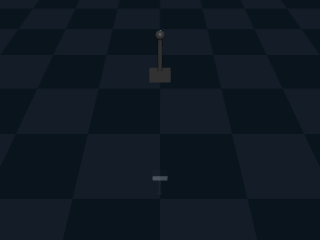

In [61]:
show_gif(model_1,data_1)

由于初始时刻轻杆处于竖直位置，因此在理想条件下将保持竖直状态。

初始条件2的可视化仿真

In [62]:
qpos_2 = '"0 -0.78"'  #设置初始位置
qvel_2 = '"0 0"'  #设置初速度
det_T = '"0.002"' #设置步长

modelxml_2 = init_model(qpos_2,qvel_2,det_T)
model_2 = mujoco.MjModel.from_xml_string(modelxml_2)
data_2 = mujoco.MjData(model_2)
mujoco.mj_resetDataKeyframe(model_2, data_2,0)
viewer.launch(model_2,data_2)

以GIF形式输出结果

""

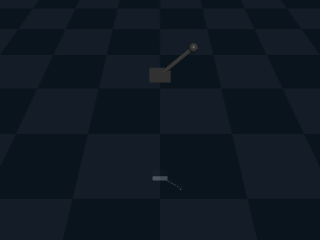

In [63]:
show_gif(model_2,data_1)

该初始条件下，轻杆有一个顺时针与竖直方向成约45°的偏移角，因此在没有外力输入的情况下，形成单摆。

5、(a) 选择恰当的Q,R矩阵，计算K矩阵
- 增加角度$x_2$的权重会使控制器更积极地校正杆的角度
- 增加位置$x_1$的权重会限制小车的移动范围
- 增加速度项$(x_3,x_4)$的权重会使系统响应更平滑
- 减小R值会使控制器使用更大的控制力，响应更快但可能不稳定
- 增大R值会使控制更温和，但可能无法有效稳定系统

In [64]:
# define customized controller which returns the feedback control action
# you can implement your controller here 

# 以下为原文件示例代码
# def myControl(model, data):
#     x = np.hstack((data.qpos,data.qvel))
#     xref = np.array([0, np.pi, 0, 0])
#     x_error = x-xref
#     K = np.array([-0.5, 0.5, 0, 0])
#     u = K@x_error
#     data.ctrl = u
#     return 
def setup_lqr_k(A_discrete = A_discrete, B_discrete = B_discrete):
 
    A = A_discrete
    B = B_discrete
    Q = np.diag([100000, 0.1, 10, 10])
    R = np.array([[100]])
    
    P = scipy.linalg.solve_discrete_are(A, B, Q, R)
    K = np.linalg.solve(R + B.T @ P @ B, B.T @ P @ A)

    return K

def lqr_controller(model, data, K):
    # 获取当前状态
    x = np.array([
        data.qpos[0],        # 小车位置x1
        -data.qpos[1], # 杆角度x2（相对于竖直向上位置）
        data.qvel[0],        # 小车速度x3
        data.qvel[1]         # 杆角速度x4
    ])
    u = - K @ x

    # 将控制输入限制在合理范围内
    #u = np.clip(u, -50, 50)
    return u,x # 返回标量控制输入和当前状态

#计算K
K = setup_lqr_k()
print(f"K = {K}")

K = [[ -31.25630961 -356.25310927  -39.81346949   78.18922588]]


在不同初始条件下的仿真

In [65]:
qpos_3 = '"-0.1 0.1"'  #设置初始位置
qvel_3 = '"0.1 0.1"'  #设置初速度
det_T = '"0.002"'  #设置步长
T = 0.002

modelxml_3 = init_model(qpos_3,qvel_3,det_T)  #初始化模型
model_3 = mujoco.MjModel.from_xml_string(modelxml_3)
data_3 = mujoco.MjData(model_3)
mujoco.mj_resetDataKeyframe(model_3, data_3,0)

# 数据记录：小车位置、杆角度、时间
cart_position_data = []
pole_angle_data = []
time_data = []

start_time = time.time()

with viewer.launch_passive(model_3, data_3) as v:  
  # launch_passive means all the simulation should be done by the user 
  
  start = time.time()
  i = 0
  while v.is_running() and time.time() - start < 20:
    step_start = time.time()
    # data.ctrl = 0.2*myControl(model,data)
    data_3.ctrl,x = lqr_controller(model_3, data_3, K)
    mujoco.mj_step(model_3, data_3)

     # 记录数据
    if i % 10 == 0:
      cart_position_data.append(x[0])
      pole_angle_data.append(x[1])
      time_data.append(T * 10 * i)
    i += 1


  # let viewer show updated info
    v.sync()
    
  # #  make sure the while loop is called every sampling period 
    # computation inside the loop may take some nontrivial time. 
    time_until_next_step = model_3.opt.timestep - (time.time() - step_start)
    if time_until_next_step > 0:
      time.sleep(time_until_next_step)


绘制图片

In [66]:
def plot(time_data,cart_position_data,pole_angle_data):    
    plt.figure(figsize=(10, 6))

    # 在仿真结束后绘图
    plt.figure(figsize=(10, 6))

    # 子图1：小车位置
    plt.subplot(2, 1, 1)
    plt.plot(time_data, cart_position_data, label='Cart Position (m)', color='b')
    plt.title('Cart Position vs Step')
    plt.xlabel('Step')
    plt.ylabel('Position (m)')

    # 子图2：杆角度
    plt.subplot(2, 1, 2)
    plt.plot(time_data, pole_angle_data, label='Pole Angle (rad)', color='r')
    plt.title('Pole Angle vs Step')
    plt.xlabel('Step')
    plt.ylabel('Angle (radians)')

    # 显示图形
    plt.tight_layout()
    plt.show()

<Figure size 1000x600 with 0 Axes>

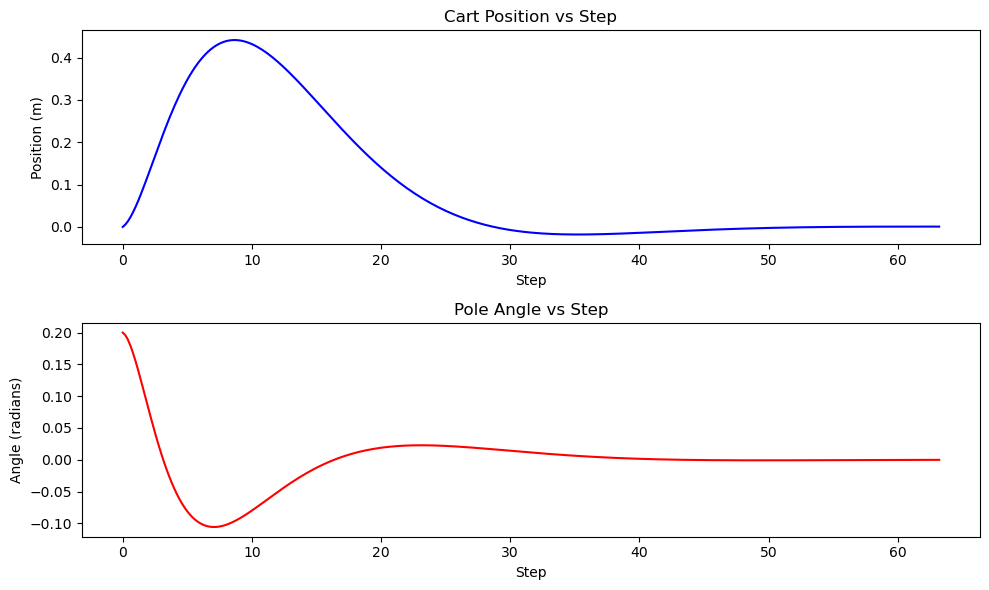

In [71]:
plot(time_data,cart_position_data,pole_angle_data)

初始条件2

In [72]:
qpos_4 = '"0 -0.2"'  #设置初始位置
qvel_4 = '"0.2 0.1"'  #设置初速度
det_T = '"0.002"'  #设置步长
T = 0.002

modelxml_4 = init_model(qpos_4,qvel_4,det_T)  #初始化模型
model_4 = mujoco.MjModel.from_xml_string(modelxml_4)
data_4 = mujoco.MjData(model_4)
mujoco.mj_resetDataKeyframe(model_4, data_4,0)

# 数据记录：小车位置、杆角度、时间
cart_position_data = []
pole_angle_data = []
time_data = []

start_time = time.time()

with viewer.launch_passive(model_4, data_4) as v:  
  # launch_passive means all the simulation should be done by the user 
  
  start = time.time()
  i = 0
  while v.is_running() and time.time() - start < 20:
    step_start = time.time()
    # data.ctrl = 0.2*myControl(model,data)
    data_4.ctrl,x = lqr_controller(model_4, data_4, K)
    mujoco.mj_step(model_4, data_4)

     # 记录数据
    if i % 10 == 0:
      cart_position_data.append(x[0])
      pole_angle_data.append(x[1])
      time_data.append(T * 10 * i)
    i += 1


  # let viewer show updated info
    v.sync()
    
  # #  make sure the while loop is called every sampling period 
    # computation inside the loop may take some nontrivial time. 
    time_until_next_step = model_4.opt.timestep - (time.time() - step_start)
    if time_until_next_step > 0:
      time.sleep(time_until_next_step)

绘制图像

<Figure size 1000x600 with 0 Axes>

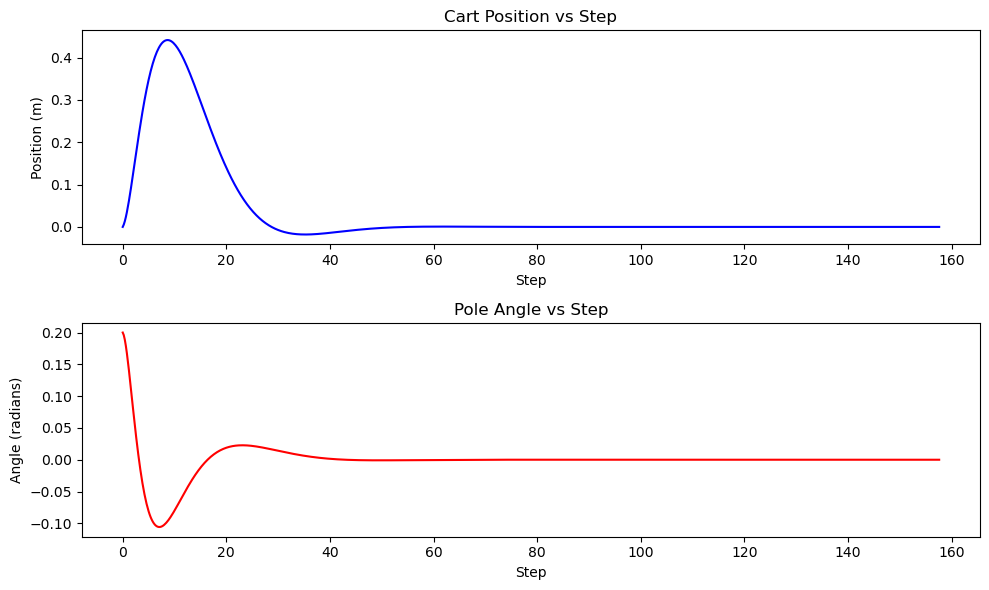

In [73]:
plot(time_data,cart_position_data,pole_angle_data)